In [1]:
import pandas as pd
import os 
from src.files import XMLFile, FASTAFile, GBFFFile
from src import get_genome_id
from src.sampler import Sampler 
from src.dataset import Dataset
from torch.utils.data import DataLoader
from utils import * 
from src.genome import ReferenceGenome
from src.tools import NCBIDatasets, Prodigal
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import dataframe_image as dfi
from sklearn.model_selection import train_test_split

%load_ext autoreload 
%autoreload 2

In [2]:
ref_out_df = load_ref_out()
ref_out_df = remove_partial(ref_out_df)

ref_out_fp_df = ref_out_df[ref_out_df.n_valid_hits == 0].copy()
ref_out_tp_df = ref_out_df[(ref_out_df.n_valid_hits > 0)].copy()

load_ref_out: 100%|██████████| 137/137 [00:08<00:00, 15.47it/s]


remove_partial: Removing 4364 instances marked as partial by both Prodigal and RefSeq from the DataFrame.


In [3]:
print('Maximum false positive length:', ref_out_fp_df.seq.apply(len).max())
print('Minimum false positive length:', ref_out_fp_df.seq.apply(len).min())

Maximum false positive length: 6469
Minimum false positive length: 29


/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


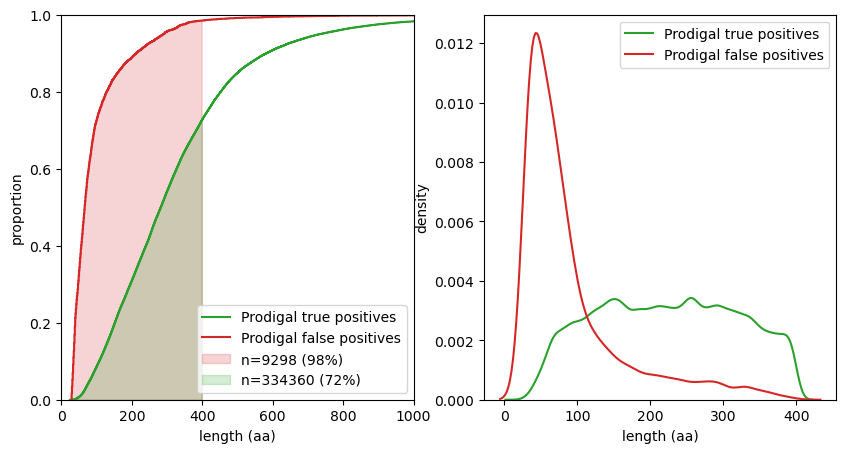

In [4]:
def figure_1(ref_out_df, path:str='../figures/filter-figure_1.png'):

    ref_out_fp_df = ref_out_df[ref_out_df.n_valid_hits == 0].copy()
    ref_out_tp_df = ref_out_df[(ref_out_df.n_valid_hits > 0)].copy()

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

    ax = axes[0]
    ax = sns.ecdfplot(ref_out_tp_df.seq.apply(len), ax=ax, color='tab:green', label=f'Prodigal true positives')
    ax = sns.ecdfplot(ref_out_fp_df.seq.apply(len), ax=ax, color='tab:red', label=f'Prodigal false positives')

    x_tp, y_tp = ax.get_lines()[0].get_data()
    x_fp, y_fp = ax.get_lines()[1].get_data()

    x_tp, x_fp, y_tp, y_fp = x_tp[1:], x_fp[1:], y_tp[1:], y_fp[1:]

    max_length = 400

    n_tp = (x_tp < max_length).sum()
    n_fp = (x_fp < max_length).sum()
    p_tp = int(n_tp * 100 / len(x_tp))
    p_fp = int(n_fp * 100 / len(x_fp))

    ax.fill_between(x_fp[x_fp < max_length], y_fp[x_fp < max_length], color='tab:red', alpha=0.2, label=f'n={n_fp} ({p_fp}%)')
    ax.fill_between(x_tp[x_tp < max_length], y_tp[x_tp < max_length], color='tab:green', alpha=0.2, label=f'n={n_tp} ({p_tp}%)')
    ax.set_xlim(0, 1000)
    ax.set_ylabel('proportion')
    ax.set_xlabel('length (aa)')
    ax.legend()

    ax = axes[1]
    ref_out_tp_df = ref_out_tp_df[ref_out_tp_df.seq.apply(len) < max_length]
    ref_out_fp_df = ref_out_fp_df[ref_out_fp_df.seq.apply(len) < max_length]
    sns.kdeplot(ref_out_tp_df.seq.apply(len), ax=ax, color='tab:green', label=f'Prodigal true positives')
    sns.kdeplot(ref_out_fp_df.seq.apply(len), ax=ax, color='tab:red', label=f'Prodigal false positives')
    ax.legend()
    ax.set_ylabel('density')
    ax.set_xlabel('length (aa)')

    plt.show()

figure_1(ref_out_df)

In [5]:
# The length distributions differ enough that I am a little worried that the model will take the "easy" way out and just
# learn sequence length. 
dataset_df = pd.concat([ref_out_fp_df.assign(label=1), ref_out_tp_df.assign(label=0)], axis=0)
dataset_df = dataset_df[dataset_df.seq.apply(len) < 400]

train_dataset_df, test_dataset_df = train_test_split(dataset_df, test_size=0.2, train_size=0.8)
train_dataset_df.convert_dtypes().to_csv('../data/filter_dataset_train.csv')
test_dataset_df.convert_dtypes().to_csv('../data/filter_dataset_test.csv')

In [6]:
def fix_dtypes(df:pd.DataFrame):
    df = df.copy().convert_dtypes()
    for col in df.columns:
        if df[col].dtype == 'string[python]':
            df[col] = df[col].fillna('none')
        if df[col].dtype == 'boolean':
            df[col] = df[col].fillna(False)
        if df[col].dtype in ['Int64', 'Float64']:
            df[col].fillna(-1)
    return df 

fix_dtypes(train_dataset_df).to_csv('../data/filter_dataset_train.csv')
fix_dtypes(test_dataset_df).to_csv('../data/filter_dataset_test.csv')

In [7]:
print((train_dataset_df.label == 0).sum() / len(train_dataset_df))
print((train_dataset_df.label == 1).sum() / len(train_dataset_df))
print((test_dataset_df.label == 0).sum() / len(test_dataset_df))
print((test_dataset_df.label == 1).sum() / len(test_dataset_df))

0.9729381724536784
0.027061827546321554
0.972967467846127
0.027032532153873013


In [53]:
# I want to make sure that the batch samplers are working as expected. 
dataset = Dataset.from_hdf('../data/filter_dataset_test.h5', feature_type='esm_650m_gap')

In [54]:
sampler = Sampler(dataset, balance_lengths=True, balance_classes=True, sample_size=len(dataset)*10)
dataloader = DataLoader(dataset, sampler=sampler, batch_size=16)

In [60]:
seqs_tp, seqs_fp = [], []
ids_tp, ids_fp = [], []

for batch in dataloader:
    # seqs, ids = np.array(batch['seq']), np.array(batch['index'])
    # labels = batch['label'].numpy()
    # seqs_tp += list(seqs[labels == 0])
    # seqs_fp += list(seqs[labels == 1])
    # ids_tp += list(ids[labels == 0])
    # ids_fp += list(ids[labels == 1])
    print(batch)

{'embedding': tensor([[[ 0.0787, -0.0816,  0.0509,  ..., -0.0829, -0.0607,  0.1189],
         [ 0.0418,  0.0233,  0.1000,  ...,  0.0243, -0.0748, -0.0648],
         [-0.0141, -0.0239,  0.0484,  ..., -0.1484,  0.0751,  0.0486],
         ...,
         [ 0.0506,  0.0017, -0.0734,  ..., -0.1389, -0.0299,  0.0034],
         [ 0.0126, -0.0484, -0.0434,  ..., -0.1171, -0.0207,  0.0257],
         [ 0.0433, -0.1144, -0.0385,  ..., -0.1938, -0.0277,  0.0109]],

        [[ 0.0212, -0.1393, -0.0222,  ..., -0.1302, -0.0404,  0.0129],
         [-0.0100, -0.0205,  0.0219,  ..., -0.1846, -0.0029,  0.0444],
         [ 0.0849, -0.0290, -0.0242,  ...,  0.0100, -0.1812, -0.0042],
         ...,
         [-0.0055, -0.0537, -0.0398,  ..., -0.1030, -0.0228,  0.1209],
         [ 0.0188,  0.0343, -0.0256,  ..., -0.0848, -0.0213,  0.0483],
         [-0.0198, -0.0088, -0.0139,  ..., -0.0363, -0.0606,  0.0262]],

        [[-0.0383, -0.0175, -0.0112,  ..., -0.1580,  0.0414,  0.0252],
         [ 0.0475, -0.0985, -0.

KeyboardInterrupt: 

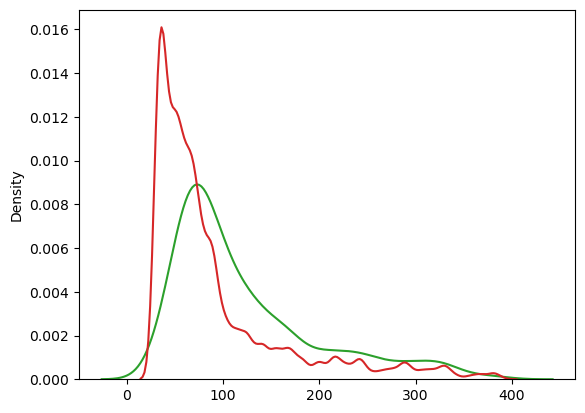

In [45]:
fig, ax = plt.subplots()

sns.kdeplot([len(seq) for seq in seqs_tp], ax=ax, color='tab:green')
sns.kdeplot([len(seq) for seq in seqs_fp], ax=ax, color='tab:red')
plt.show()

In [14]:
print(len(ids_fp))

1849


In [15]:
len(dataset)

68732